# Linear Regression on MNIST in Numpy Tutorial

In this notebook, we will write a script to perform a linear regression on the MNIST dataset from scratch in Numpy, without a framework like Tensorflow or Keras. For the sake of consistency with more complex networks, we will use Stochastic Gradient Descent (SGD) to perform the regression, instead of the more efficient least squares optimization. This will allow us to add one more layer and make a logistic regression classifier in the next lesson.

## Load and Preprocess Data

This will be a duplicate of my other tutorial on CNNs, so the description will be the same. We will load the data, perform a per-pixel normalization, and encode the labels. To start, we'll import the MNIST data without one-hot encoding - we'll do that ourselves later. If you'd rather avoid one-hot encoding manually, just set `one_hot=True` and make the necessary adjustments. We will also load the data manually, even though just using the mnist.train.next_batch command can be easier.

In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data # downloads MNIST images

mnist = input_data.read_data_sets('MNIST_data', one_hot=False) 

data, labels = mnist.train.next_batch(50000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We then divide the dataset into train and validation datasets, and preprocess them. We subtract the per-pixel mean (the average of each pixel over the entire training set, which sets the mean to zero, and the standard deviation, in this case, to about .25.

In [3]:
data = data.reshape(50000, 28, 28, 1)

temp_data = data - np.mean(data, axis=0)

train_dataset = temp_data[:45000].reshape(45000, 784)
train_labels = labels[:45000]

valid_dataset = temp_data[45000:].reshape(5000, 784)
valid_labels = labels[45000:]

print("Mean: %f, Std: %f" % (np.mean(train_dataset), np.std(train_dataset)))

Mean: -0.000055, Std: 0.259276


## Verify data

We can use the matplotlib.pyplot module to view some of the sample images and their corresponding labels. The data is encoded by defaut as a single `(784, 1)` Numpy array, so we need to manually reshape it in order to display the correct image.

Number: 2


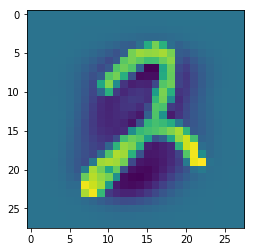

In [4]:
import matplotlib.pyplot as plt
import random

n = random.randint(0, len(valid_dataset))

image = valid_dataset[n] #mnist.train.next_batch(1)
print("Number: {}".format(valid_labels[n]))

plt.imshow(image.reshape(28, 28))

plt.show()

## Utilities:

These are utilities for processing the data and handling the process of training the model.

### One-hot encode labels:

We can use a very concise but somewhat sophisticated script to one-hot encode the labels. The inner statement in parenthesis uses Numpy broadcasting to convert the arange array, with shape `(10, )`, into an array of shape `(10, len(labels))`, and the labels array, with shape `(len(labels),)`, into an array with shape `(len(labels), 1)`. The `[:,None]` syntax creates a new axis with length 1. The two arrays are then compared elementwise, returning a boolean array which is `True` in the desired position. We then cast the boolean values as integers, to get our one-hot encoded labels.

In [8]:
def encode_labels(labels):
    return (np.arange(10) == labels[:,None]).astype(np.uint8)

In [9]:
train_labels_encoded = encode_labels(train_labels)
valid_labels_encoded = encode_labels(valid_labels)

print("Label: ", train_labels[2], "Encoded label: ", train_labels_encoded[2])

Label:  5 Encoded label:  [0 0 0 0 0 1 0 0 0 0]


### Generate batches from preprocessed data:

This is pretty self explanatory. Given a dataset and the corresponding labels, it generates a random set of examples of the desired size.

In [10]:
def next_batch(dataset, labels, batch_size):
    indices = random.sample(range(len(dataset)), batch_size)
    batch_data = dataset[indices]
    batch_labels = labels[indices].reshape(batch_size,10)
    return batch_data, batch_labels

### Evaluate Model Accuracy

This will compute the argmax (index of maximum element of predicted encoded labels), and compare that to the actual label.

In [86]:
def evaluate(size, weights, biases):
    data, labels = next_batch(valid_dataset, valid_labels_encoded, size)
    prediction = predict(data, weights, biases)
    accuracy = (np.argmax(prediction, axis=1) == np.argmax(labels, axis=1)).sum() * 100 / size
    print("The accuracy of your model is %s%%!" % accuracy)
    return accuracy

## Model Setup

This is the meat of the linear regression optimization, and it is presented in two implementations. The first is an iterative version, which is more intuitive but far less efficient than the vectorized version. Numpy has a number of high efficiency vectorized operations which are precompiled in C, and we can take advantage of the compiled code if we write it without loops.

Since this is just linear regression, our model is very simple. We just have a single matrix, with shape `10x784`, which we multiply by the pixels in our image to predict a probability distribution over our 10 classes (and a bias). The gradient of a linear transformation is extremely simple: it's just the matrix itself. So for each weight, we just have to compute the gradient of the loss. We will use an L2 loss, so the calculus looks like this:

$$ L = \frac{1}{2}\sum_{i}^{\text{batch size}}\sum_j^{10} (p_{ij} - \text{label}_{ij})^2$$

where $p_{ij}$ is the $j$th component of the $i$th prediction in the minibatch. Specifically,

$$p_i = W\cdot x_i + b$$

where $x_i$ is the $i$th image in the dataset. We add the one-half to cancel out the square during differentiation. Therefore:

$$\frac{\partial L}{\partial w_{m n}} = \sum_{i}^{\text{batch size}} (p_{im} - \text{label}_{im})\cdot x_{in}$$.

First, we define the learning rate, which controls how much the weights are updated at each step. 

In [126]:
batch_size = 500
iterations = 401

#learning_rate = .2*np.exp(-3*np.arange(0,iterations) / iterations) # exponential learning rate
# learning_rate = np.array([.05*(1 - x/iterations) for x in range(iterations)]) # linear learning rate
learning_rate = .2* np.ones(iterations) # linear learning rate


def predict(data, weights, biases):
    #print("Predict data:", np.argmax(data[0:5], axis=1))
    """Predicts an encoded label for a given image (multiplies the image by the weight matrix and adds the bias)."""
    return np.dot(data, weights.T) + biases.T

def linear_regression(batch_size, iterations, learning_rate):
    """For i iterations, computes the loss, and then calculates the gradient for each of the weights and biases."""
    
    weights = np.random.randn(10, 784) # initialize weights to normal distribution
    biases = np.random.randn(10)

    for i in range(iterations):
        data, labels = next_batch(train_dataset, train_labels_encoded, batch_size)
        prediction = predict(data, weights, biases) 
        error_arr = labels - prediction
        loss = np.tensordot(error_arr, error_arr) / (2*batch_size)
        if i % 10 == 0:
            print("Loss at step %s is %s" % (i, loss))
        if i % 50 == 0:
            evaluate(512, weights, biases)
        dW = np.zeros_like(weights)
        dB = np.zeros_like(biases)
        for j in range(np.shape(weights)[0]):
            for k in range(np.shape(weights)[1]):
                dW[j,k]= - np.sum((labels-prediction)[:, j] * data[:, k]) / batch_size
        for j in range(len(biases)):
            dB[j]= - np.sum((labels-prediction)[:, j]) / batch_size

        weights = weights - learning_rate[i]*dW
        biases = biases - learning_rate[i]*dB

    return weights, biases

In [127]:
weights, biases = linear_regression(batch_size, iterations, learning_rate)

Loss at step 0 is 300.194849182
The accuracy of your model is 9.765625%!
Loss at step 10 is 54.1172580969
Loss at step 20 is 35.3476123198
Loss at step 30 is 27.8820963894
Loss at step 40 is 22.2641059254
Loss at step 50 is 19.2610970945
The accuracy of your model is 12.890625%!
Loss at step 60 is 17.4446407037
Loss at step 70 is 14.9998902915
Loss at step 80 is 13.8840358746
Loss at step 90 is 12.6696528459
Loss at step 100 is 11.9472870476
The accuracy of your model is 18.9453125%!
Loss at step 110 is 11.1995934117
Loss at step 120 is 9.76998217169
Loss at step 130 is 9.34830128248
Loss at step 140 is 9.25743411949
Loss at step 150 is 9.14742682457
The accuracy of your model is 18.359375%!
Loss at step 160 is 8.05281726146
Loss at step 170 is 7.83602981463
Loss at step 180 is 7.53155884156
Loss at step 190 is 6.95065720402
Loss at step 200 is 7.02660445715
The accuracy of your model is 25.0%!
Loss at step 210 is 6.48889249862
Loss at step 220 is 6.04254583501
Loss at step 230 is 6.24

As you can see, linear regression really isn't doing a great job of capturing the complexity of the MNIST dataset. However, it can be a very useful tool, and we'll find that with the addition of a logistic layer, it can perform quite well. But before that, let's vectorize this example.

**Vectorization** is the process of converting an iterative/loop based algorithm into something that uses Numpy's built-in, pre-compiled methods. The code is much faster, and much more compact.

In [142]:
batch_size = 500
iterations = 2001

learning_rate = .4*np.exp(-5*np.arange(0,iterations) / iterations) # exponential learning rate
# learning_rate = np.array([.05*(1 - x/iterations) for x in range(iterations)]) # linear learning rate
#learning_rate = .2* np.ones(iterations) # linear learning rate

def vectorized_linear_regression(batch_size, iterations, learning_rate):
    
    weights = np.random.randn(10, 784) # initialize weights to normal distribution
    biases = np.random.randn(10, 1)
    
    for i in range(iterations):
        data, labels = next_batch(train_dataset, train_labels_encoded, batch_size)
        prediction = predict(data, weights, biases)
        error_arr = labels - prediction
        loss = np.tensordot(error_arr, error_arr) / (2*batch_size)
        if i % 50 == 0: print("Loss at step %s is %s" % (i, loss))
        dW = - np.sum(error_arr[..., None] * data[:, None, :], axis=0) / batch_size
        dB = - np.sum(error_arr, axis=0)[:, None] / batch_size
        weights = weights - learning_rate[i]*dW
        biases = biases - learning_rate[i]*dB
        
        if i % 300 == 0:
            evaluate(512, weights, biases)

    return weights, biases

In [143]:
weights, biases = vectorized_linear_regression(batch_size, iterations, learning_rate)

Loss at step 0 is 269.230131634
The accuracy of your model is 9.765625%!
Loss at step 50 is 12.7985945259
Loss at step 100 is 7.58873564243
Loss at step 150 is 5.62362972117
Loss at step 200 is 4.54804419135
Loss at step 250 is 3.61121634433
Loss at step 300 is 3.13486886243
The accuracy of your model is 27.1484375%!
Loss at step 350 is 2.83787208575
Loss at step 400 is 2.77736766216
Loss at step 450 is 2.49060247774
Loss at step 500 is 2.21586026204
Loss at step 550 is 2.17008208553
Loss at step 600 is 2.11486219364
The accuracy of your model is 36.5234375%!
Loss at step 650 is 1.99350500395
Loss at step 700 is 2.03029032889
Loss at step 750 is 1.91548918287
Loss at step 800 is 1.91941634693
Loss at step 850 is 1.76436628185
Loss at step 900 is 1.74610586957
The accuracy of your model is 41.015625%!
Loss at step 950 is 1.70749525562
Loss at step 1000 is 1.84194906092
Loss at step 1050 is 1.7252152309
Loss at step 1100 is 1.66007152463
Loss at step 1150 is 1.8182176767
Loss at step 120

Notice how much faster this method is, and how much more quickly it converges to a useful model. This is the power of vectorization, and why Numpy is such a great tool for any sort of scientific computing in Python. See my next notebook on Logistic regression, where we'll take this a step further!